# Scraping and Analysis for Fashion Product Design and Pricing 

This notebook covers the data analysis and conclusion. From webscrapping the insertion of the data into the database is in the file **hm_etl.py**.

# 💡 Problem Statement

Mariana and Laura are friends and business partners. After several successful businesses, they are planning to enter the US fashion market as an e-commerce business model. The initial idea is to enter the market with only one product and for a specific public, in this case the product would be jeans for the female public. The goal is to keep the cost of operation low and scale up as they get customers. However, even with the entrance product and the audience defined, the partners have no experience in this fashion market and therefore do not know how to define basic things like price, the type of jeans, and the main materials to manufacture each piece.
So the partners hired a Data Science consultancy to answer the following questions: 

1. What is the average selling price for the jeans? 
2. How many types of pants and their colors for the initial product? 
3. What raw materials are needed to make the jeans?

The company's main competitor is H&M.


# 🎯 Solution Planning

1. Business Understanding
2. ETL Architeture Design (ETL image here)
3. Web Scraping (Extract the Data)
4. Data Cleaning (Transforming)
5. Save data into the Database (Load)
6. Data Analyisis
7. Delivery of the Answers and The Insights Via Report

# 0.0 Imports

In [1]:
import pandas             as pd
import numpy              as np
import seaborn            as sns

import plotly.express     as px
import matplotlib.pyplot  as plt

from IPython.core.display import HTML
from sqlalchemy           import create_engine
from matplotlib.ticker    import PercentFormatter

## 0.1 Helper Functions

In [2]:
def personal_settings():
    
    # notebook
    display(HTML('<style>.container{width:98% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.options.display.float_format = '{:.2f}'.format
    
    # seaborn
    sns.set(rc={'figure.figsize':(22,10)})
    sns.set_theme(style = 'darkgrid', font_scale = 1.2)
    sns.set_palette('RdBu_r')
    
    return None

def plot_pareto_by(df_, group_by, column, figsize):
    
    df = df_.groupby(group_by)[column].count().reset_index()
    df = df.sort_values(by=column,ascending=False)

    df["cumpercentage"] = df[column].cumsum()/df[column].sum()*100

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(df[group_by], df[column], color="C0")
    
    ax2 = ax.twinx()
    ax2.plot(df[group_by], df["cumpercentage"], color="C1", marker="D", ms=7)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
        
    plt.show()
    
    return None

def cumultive_percentage(df, group_by, column):
    aux = df[[column, group_by]].groupby(group_by).count().sort_values(column, ascending=False).reset_index()
    #aux['%culm_'+group_by] = (aux.index + 1)/aux[group_by].count()*100
    aux['%culm_'+column] = aux[column].cumsum()/aux[column].sum()*100
    
    return aux

In [3]:
personal_settings()

## 0.2 Loading Data

In [4]:
database_name = 'database_hm.db'
conn = create_engine('sqlite:///' + database_name, echo=False)

In [5]:
query = """
    SELECT * FROM hm_products;
"""

In [6]:
df_raw = pd.read_sql(query, con=conn)

# 1.0 Data Description

In [7]:
df1 = df_raw.copy()
df1.head()

,product_id,price,name,color_id,color_name,style_id,style,length,waist,fit,...,spandex,polyester,elastomultiester,modal,rayon,copolyester,elastodiene,lyocell,other_fibres,scrapy_datetime
0,0941666001,24.99,slim_mom_high_ankle_jeans,001,denim_blue,0941666,mom_tapered,ankle,high,slim,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,2022-07-07 15:11:50
1,0941666002,24.99,slim_mom_high_ankle_jeans,002,black,0941666,mom_tapered,ankle,high,slim,...,0.01,0.27,0.00,0.00,0.03,0.00,0.00,0.00,0.03,2022-07-07 15:11:50
2,0941666003,24.99,slim_mom_high_ankle_jeans,003,cream,0941666,mom_tapered,ankle,high,slim,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2022-07-07 15:11:50
3,0941666004,24.99,slim_mom_high_ankle_jeans,004,medium_blue,0941666,mom_tapered,ankle,high,slim,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,2022-07-07 15:11:50
4,0941666005,24.99,slim_mom_high_ankle_jeans,005,black_washed,0941666,mom_tapered,ankle,high,slim,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,2022-07-07 15:11:50


## 1.2 Data Dimension

In [8]:
print(df1.shape[0], 'rows')
print(df1.shape[1], 'columns')

499 rows
22 columns


## 1.3 Data Types

In [9]:
description = []
for i in df1.columns:
    description.append([
        i,
        df1[i].dtypes,
        df1[i].nunique(),
        df1[i].drop_duplicates().sample(2, replace=True).values
    ])

pd.DataFrame(data=description, columns=['attributes','dtypes', 'nunique','sample'])

,attributes,dtypes,nunique,sample
0,product_id,object,499,"[0922835011, 0984026004]"
1,price,float64,9,"[39.99, 59.99]"
2,name,object,82,"[straight_low_cargo_jeans, slim_bootcut_high_j..."
3,color_id,object,57,"[011, 078]"
4,color_name,object,49,"[light_purple_plaid, dark_denim_gray]"
5,style_id,object,112,"[0986343, 1058081]"
6,style,object,26,"[bootcut, boyfriend_straightleg_trashed]"
7,length,object,3,"[ankle, extralong legs]"
8,waist,object,4,"[regular , regular ]"
9,fit,object,5,"[regular, relaxed]"


## 1.4 Check NA

In [10]:
description = []
for i in df1.columns:
    description.append([
        i,
        df1[i].isna().sum(),
        round((df1[i].isna().sum()/len(df1))*100)
    ])

pd.DataFrame(data=description, columns=['attributes','null', '%null'])

,attributes,null,%null
0,product_id,0,0
1,price,0,0
2,name,0,0
3,color_id,0,0
4,color_name,0,0
5,style_id,0,0
6,style,124,25
7,length,2,0
8,waist,6,1
9,fit,194,39


## 1.5 Fillout NA

To fill the NA in style and fit, a search was made relating the name to the probable style and fit. The sources of the research are:       
https://www.cosmopolitan.com/style-beauty/fashion/g26429319/types-of-jeans/         
https://www.thesun.co.uk/living/3088427/jeans-body-shape-guide-denim-fits-styles/


In [11]:
## fill style

# take all styles in a list
style_names = list(df1['style'].str.split('_', expand=True).stack().unique())

# check the names of jeans with none style
df1.loc[df1['style'].isnull(), 'name'].unique()

# styles researched -  append this style in list style_names
styles_researched = ['straight', 'slim', 'skinny']

for i in range(len(styles_researched)):
    style_names.append(styles_researched[i])

# fill None acoordin with name and style_names and 90's baggy jeans to straightleg (as seen in one research)
for i in range (len(style_names)):
    for j in range (len(df1)):
        if (style_names[i] in df1.loc[j, 'name']) & (df1.loc[j, 'style'] == None):
            df1.loc[j, 'style'] = style_names[i]
        if ('90s_baggy' in df1.loc[j, 'name']) & (df1.loc[j, 'style'] == None):
            df1.loc[j, 'style'] = 'straightleg'

In [12]:
## fill fit

# check the names of fit
df1['fit'].unique()

# check the names of jeans with none fit
df1.loc[df1['fit'].isnull(), 'name'].unique()

df1['fit'] = df1[['name', 
                  'fit']].apply(lambda x: 'loose' if ('wide'in x['name']) & (x['fit'] == None) else
                                          'regular' if (('straight' in x['name']) | ('baggy' in x['name']) | ('mom' in x['name']) | ('flared' in x['name'])) & (x['fit'] == None) else
                                          'skiny' if ('curvy' in x['name']) & (x['fit'] == None) else x['fit'], axis=1)

In [13]:
## fill waist
df1[df1['waist'].isna()]['name']

106    denim_carpenter_overalls
371      mom_fit_denim_overalls
372      mom_fit_denim_overalls
373      mom_fit_denim_overalls
374      mom_fit_denim_overalls
375      mom_fit_denim_overalls
Name: name, dtype: object

In this analysis we just want bottom part of clothes so we will drop later this rows when the product is overalls

In [14]:
## fill fibers
df1['copolyester']  = df1['copolyester'].apply(lambda x: x if x > 0 else 0)
df1['lyocell']      = df1['lyocell'].apply(lambda x: x if x > 0 else 0)
df1['other_fibres'] = df1['other_fibres'].apply(lambda x: x if x > 0 else 0)

In [15]:
# check new %NA
description = []
for i in df1.columns:
    description.append([
        i,
        df1[i].isna().sum(),
        round((df1[i].isna().sum()/len(df1))*100)
    ])

pd.DataFrame(data=description, columns=['attributes','null', '%null'])

,attributes,null,%null
0,product_id,0,0
1,price,0,0
2,name,0,0
3,color_id,0,0
4,color_name,0,0
5,style_id,0,0
6,style,13,3
7,length,2,0
8,waist,6,1
9,fit,36,7


## 1.6 Drop NA

In [16]:
df1.dropna(how='any', inplace=True)

In [17]:
df1.columns

Index(['product_id', 'price', 'name', 'color_id', 'color_name', 'style_id',
       'style', 'length', 'waist', 'fit', 'environmental_marker', 'cotton',
       'spandex', 'polyester', 'elastomultiester', 'modal', 'rayon',
       'copolyester', 'elastodiene', 'lyocell', 'other_fibres',
       'scrapy_datetime'],
      dtype='object')

## 1.7 Descriptive Statistical

In [18]:
num_attributes = df1[['price', 'cotton', 'spandex', 'polyester', 'elastomultiester', 'modal', 'rayon', 'copolyester', 'elastodiene', 'lyocell', 'other_fibres' ]]
cat_attributes = df1[['product_id', 'name', 'color_id', 'color_name', 'style_id', 'style', 'length', 'waist', 'fit', 'environmental_marker', 'scrapy_datetime']]

### 1.7.1 Numerical Attributes

In [19]:
# by the function - count, mean, std, min, quartile 1 (25%), quartile 2(50%), quartile 3 (75%) and max
aux1 = num_attributes.describe().drop('count', axis=0)

# skew and kurtosis
aux2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
aux3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate 
num_summary = pd.concat([aux1, aux2, aux3]).T.reset_index()
num_summary.columns = ['attributes','mean','std','min','25%','50%','75%','max','skew','kurtosis']
num_summary

,attributes,mean,std,min,25%,50%,75%,max,skew,kurtosis
0,price,32.34,7.45,17.99,29.99,29.99,34.99,69.99,1.03,2.12
1,cotton,0.95,0.10,0.00,0.98,0.99,1.00,1.00,-3.50,22.23
2,spandex,0.01,0.01,0.00,0.00,0.01,0.01,0.09,2.51,12.14
3,polyester,0.03,0.08,0.00,0.00,0.00,0.00,0.43,2.28,4.08
4,elastomultiester,0.00,0.01,0.00,0.00,0.00,0.00,0.08,5.43,28.86
5,modal,0.00,0.02,0.00,0.00,0.00,0.00,0.51,21.17,448.00
6,rayon,0.00,0.01,0.00,0.00,0.00,0.00,0.09,10.78,143.23
7,copolyester,0.00,0.01,0.00,0.00,0.00,0.00,0.19,21.17,448.00
8,elastodiene,0.00,0.00,0.00,0.00,0.00,0.00,0.05,21.17,448.00
9,lyocell,0.00,0.01,0.00,0.00,0.00,0.00,0.15,14.92,221.48


💡 The prices are skewed to the right, i.e. the median is lower than the mean. The median price is 29.99 USD. We will use the median as a measure of central tendency, and answer the question of the medium sales price of the products.   
💡 Almost all products have cotton. The average percentage of cotton is 95%.

### 1.7.2 Categorical Attributes

In [20]:
cat_summary = cat_attributes.astype('category').describe().T
cat_summary 

,count,unique,top,freq
product_id,448,448,0572998001,1
name,448,72,mom_high_ankle_jeans,51
color_id,448,55,001,76
color_name,448,46,light_denim_blue,122
style_id,448,100,0714790,24
style,448,24,straightleg,79
length,448,3,ankle,243
waist,448,4,high,275
fit,448,6,loose,140
environmental_marker,448,2,1,352


# 2.0 Exploratory Data Analysis

In [21]:
df2 = df1.copy()

### Count plot for numeric variables

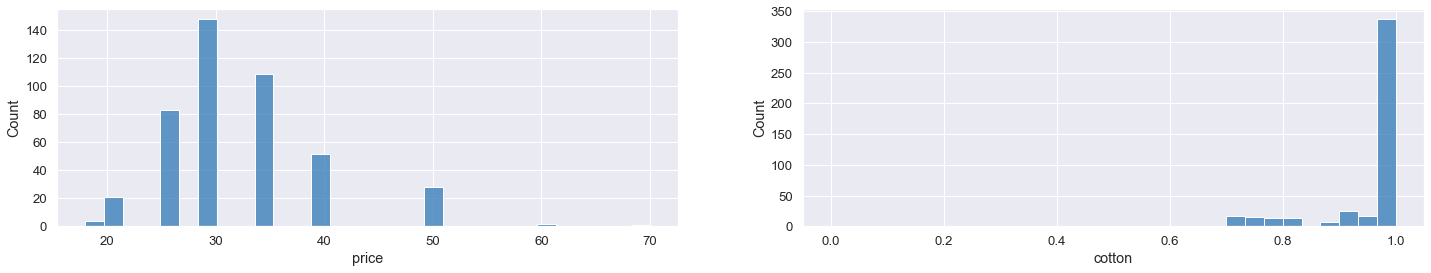

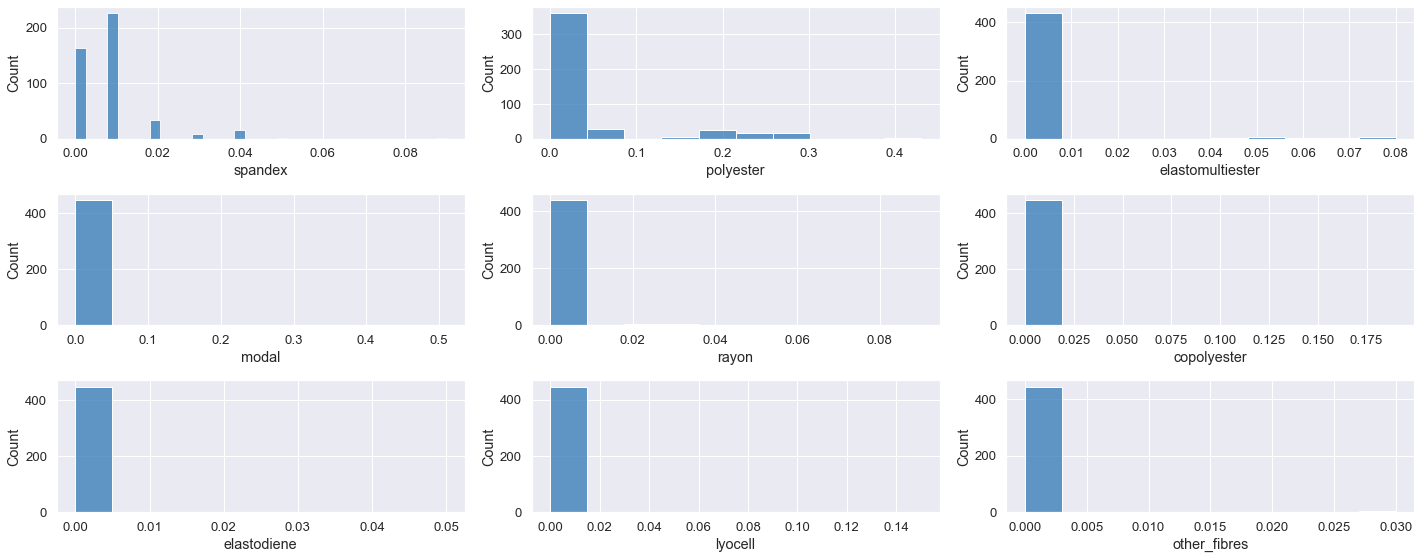

In [22]:
plt.figure(figsize= (24.5, 4))

plt.subplot(1,2,1)
sns.histplot(x='price', data=df2, bins=30)

plt.subplot(1,2,2)
sns.histplot(x='cotton', data=df2, bins=30);

cols = 3
rows = 3

num_cols = df2[['spandex', 'polyester', 'elastomultiester', 'modal', 'rayon', 'copolyester', 'elastodiene', 'lyocell', 'other_fibres']]
fig = plt.figure(figsize= (20, 8))

for i, col in enumerate(num_cols):
    ax=fig.add_subplot( rows, cols, i+1) 
    sns.histplot(x=df2[col], ax=ax)
    
fig.tight_layout()  
plt.show()

💡 As seen previously the median price is around 30 USD, and the fiber that most composes the products is cotton, with many products having a percentage close to 100%.     
💡 Many products have polyester and spadex in their composition.

### Quantity by product name

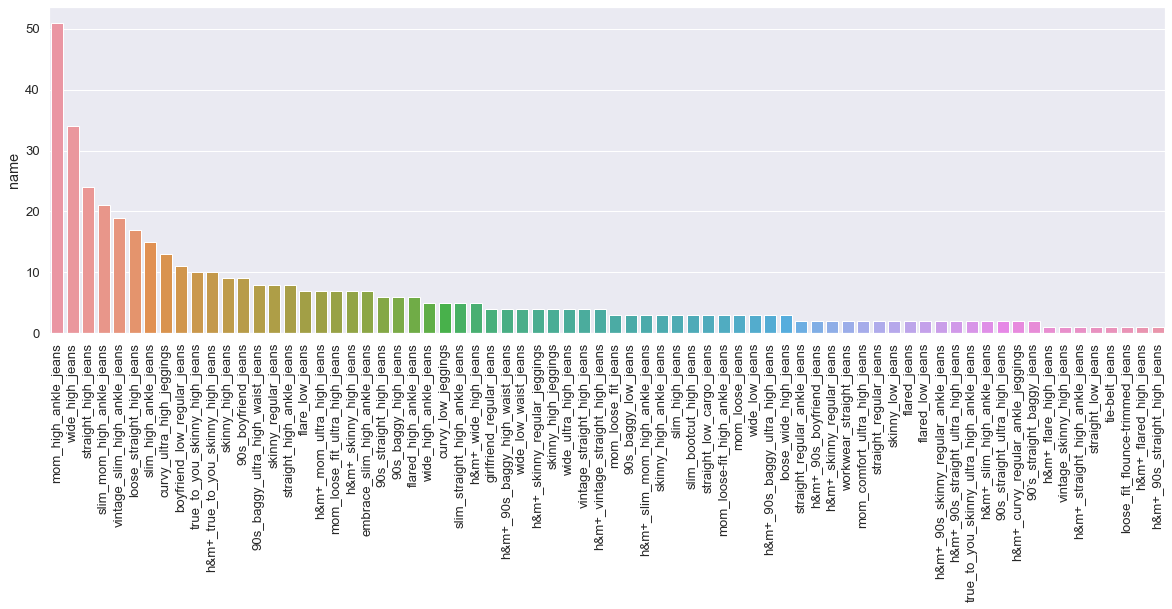

In [23]:
plt.figure(figsize= (20, 6))
sns.barplot(x=df2['name'].value_counts().index,
            y=df2['name'].value_counts())
plt.xticks(rotation=90);

### Pareto of product quantity by product color

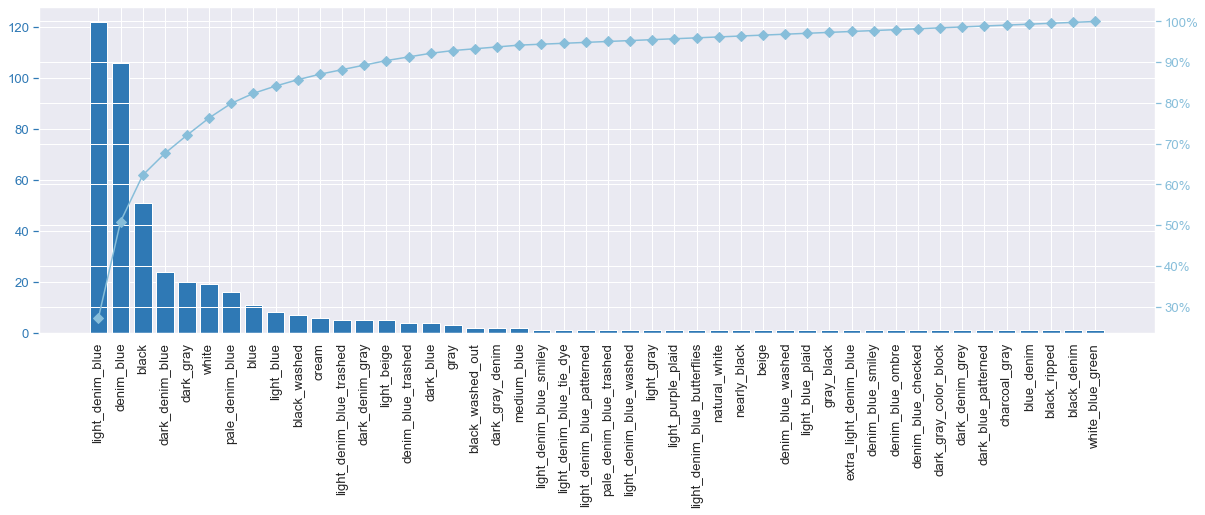

In [24]:
plot_pareto_by(df2, group_by='color_name', column='product_id', figsize=(20, 6))

💡 80% of the products focus on colors up to pale denin blue.

### Pareto of product quantity by product style

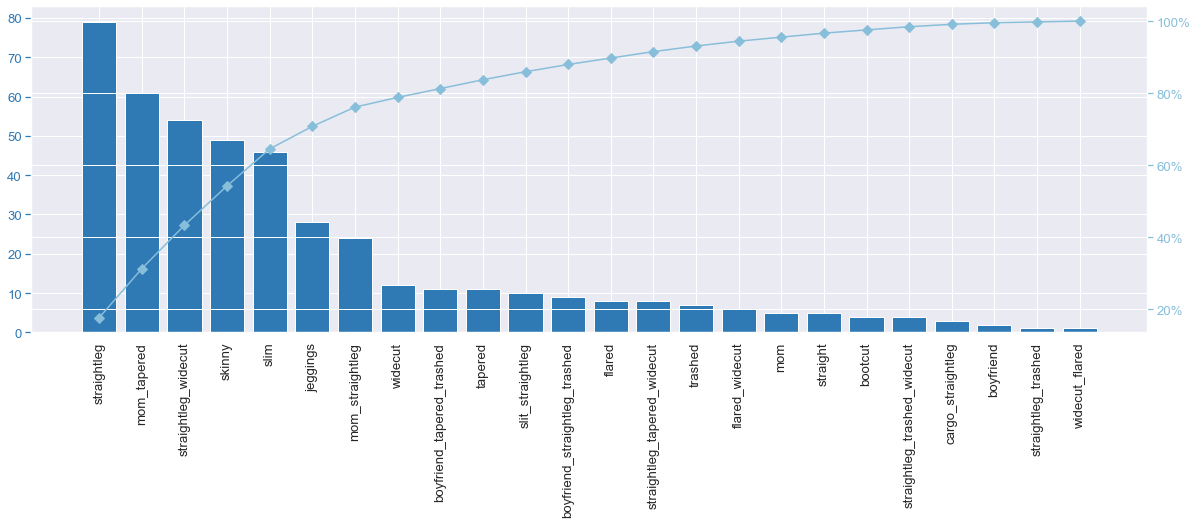

In [25]:
plot_pareto_by(df2, group_by='style', column='product_id', figsize=(20, 6))

💡 80% of the products focus on style up to widecut.

### Number of products per length

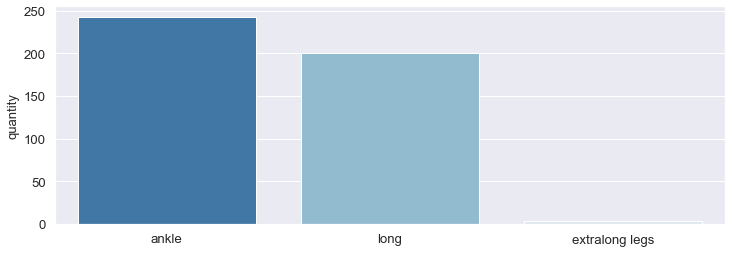

In [26]:
plt.figure(figsize= (12, 4))
sns.barplot(x=df2['length'].value_counts().index,
            y=df2['length'].value_counts())

plt.ylabel('quantity', fontsize=13);

In [27]:
cumultive_percentage(df2, 'length','product_id')

,length,product_id,%culm_product_id
0,ankle,243,54.24
1,long,201,99.11
2,extralong legs,4,100.00


💡 The ankle and long lengths represent practically 100% of the products.

### Number of products per waist

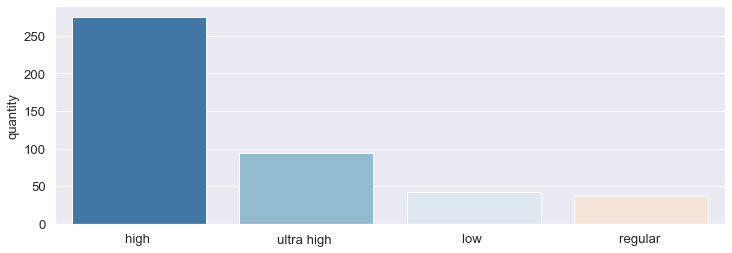

In [28]:
plt.figure(figsize= (12, 4))
sns.barplot(x=df2['waist'].value_counts().index,
            y=df2['waist'].value_counts())

plt.ylabel('quantity', fontsize=13);

In [29]:
cumultive_percentage(df2, 'waist','product_id')

,waist,product_id,%culm_product_id
0,high,275,61.38
1,ultra high,94,82.37
2,low,42,91.74
3,regular,37,100.00


💡 61.38% of the products have a higth waist and 82.37% have either a hight or ultra hight waist.

### Number of products per fit

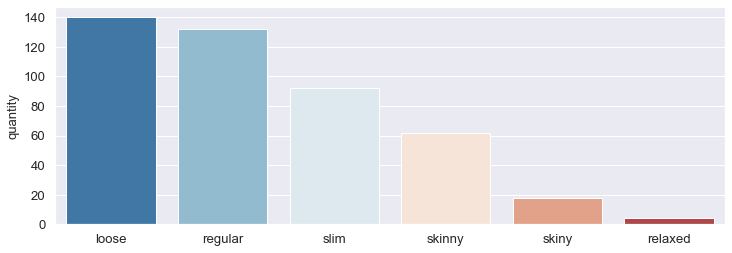

In [30]:
plt.figure(figsize= (12, 4))
sns.barplot(x=df2['fit'].value_counts().index,
            y=df2['fit'].value_counts())

plt.ylabel('quantity', fontsize=13);

In [31]:
cumultive_percentage(df2, 'fit','product_id')

,fit,product_id,%culm_product_id
0,loose,140,31.25
1,regular,132,60.71
2,slim,92,81.25
3,skinny,62,95.09
4,skiny,18,99.11
5,relaxed,4,100.00


💡 80% of the products have fit loose or regular or slim.

### Number of products that are or are not from environmental marker

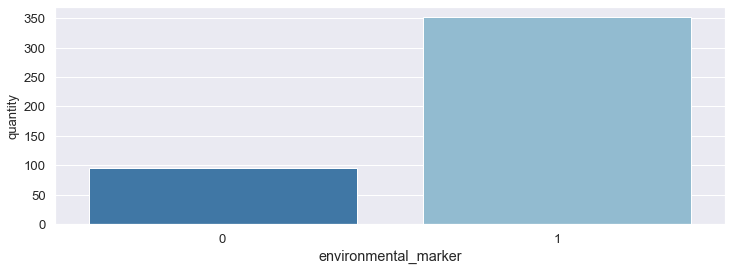

In [32]:
plt.figure(figsize= (12, 4))
sns.countplot(x='environmental_marker', data=df2)
plt.ylabel('quantity', fontsize=13);

In [33]:
cumultive_percentage(df2, 'environmental_marker','product_id')

,environmental_marker,product_id,%culm_product_id
0,1,352,78.57
1,0,96,100.00


💡 Almost 80% of the products are from environmental marker.

### Check the product with the highest price

In [34]:
df2[df2['price'] == 69.99][['cotton', 'spandex', 'polyester', 'elastomultiester', 'modal', 'rayon', 'copolyester', 'elastodiene', 'lyocell', 'other_fibres', 'environmental_marker' ]]

,cotton,spandex,polyester,elastomultiester,modal,rayon,copolyester,elastodiene,lyocell,other_fibres,environmental_marker
39,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


Its from environmental marker and the composition is cotton 100%.

### Price of products that are or are not from environmental marker

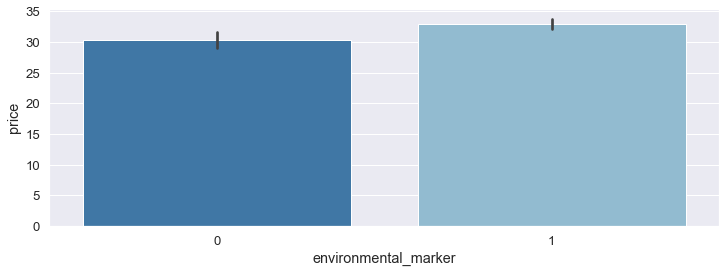

In [35]:
plt.figure(figsize= (12, 4))
sns.barplot(x='environmental_marker', y='price', data=df2);

In [36]:
aux = df2[['environmental_marker', 'price']].groupby('environmental_marker').mean().reset_index()
print(aux)

no = aux.iloc[0,1]
yes = aux.iloc[1,1]

percentage = abs(((no - yes) / no)*100)
print(f'\n Environmental marker products are {percentage:.2f}% more expensive than non-environmental marker products.')

   environmental_marker  price
0                     0  30.29
1                     1  32.90

 Environmental marker products are 8.60% more expensive than non-environmental marker products.


### Check the median price of the products that are 100% cotton and not.

In [37]:
df2['cotton100%'] = df2['cotton'].apply(lambda x: 1 if x == 1 else 0)

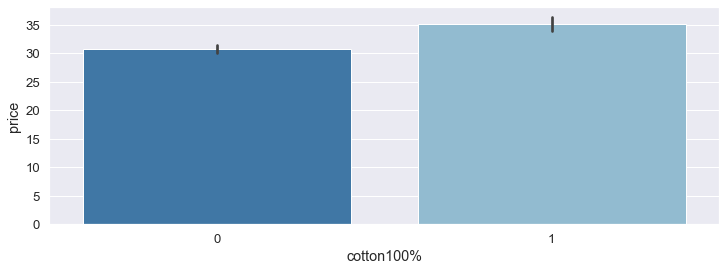

In [38]:
plt.figure(figsize= (12, 4))
sns.barplot(x='cotton100%', y='price', data=df2);

In [39]:
aux = df2[['cotton100%', 'price']].groupby('cotton100%').mean().reset_index()
print(aux)

no = aux.iloc[0,1]
yes = aux.iloc[1,1]

percentage = abs(((no - yes) / no)*100)
print(f'\n Cotton 100% products are {percentage:.2f}% more expensive than non-cotton 100% products.')

   cotton100%  price
0           0  30.76
1           1  35.13

 Cotton 100% products are 14.20% more expensive than non-cotton 100% products.


### Check the product with the lowest price

In [40]:
df2[df2['price'] == 17.99][['cotton', 'spandex', 'polyester', 'elastomultiester', 'modal', 'rayon', 'copolyester', 'elastodiene', 'lyocell', 'other_fibres', 'environmental_marker' ]]

,cotton,spandex,polyester,elastomultiester,modal,rayon,copolyester,elastodiene,lyocell,other_fibres,environmental_marker
28,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
99,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
100,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
101,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


These products are also 100% cotton, but only one is from environmental marker.    
Let's use correlation for clarity.

### Correlation matrix for numerical variables

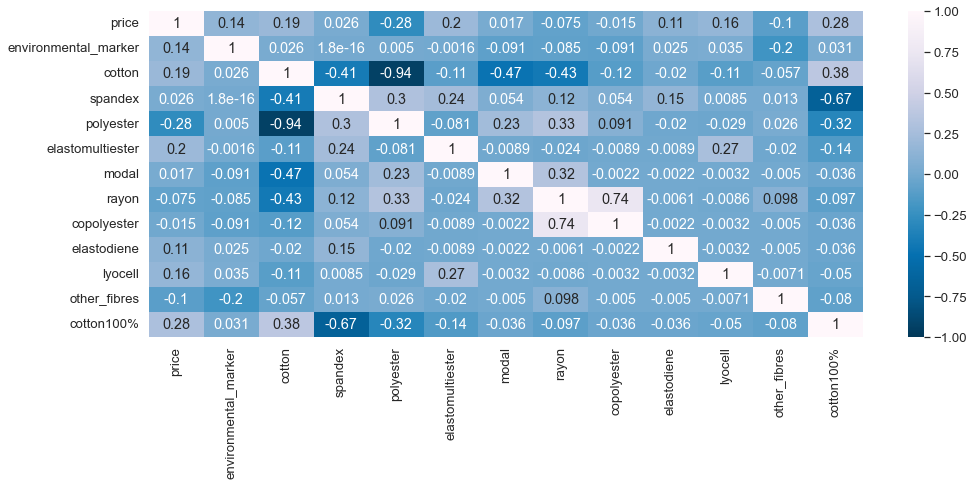

In [41]:
corr = df2.corr(method='pearson')

plt.figure(figsize=(16, 6))
sns.heatmap(corr, cmap='PuBu_r', vmin=-1, vmax=1, annot=True);

We see that the variables have a weak to very weak correlation with price, the highest correlations with price are for variables, 100% cotton, polyester (negative correlation), elastomultiester, cotton, lyocell, and environmental marker, in that particular order.

## 3.0 Conclusion

The medium price of the competitor's products is 29.99 USD. The measure of central tendency used was the median, there are outliers in the dataset.    
Products with polyester should be sold below the median price, the correlation between them is negative, which makes sense because polyester is not considered a noble textile material.    
Products from the environmental market can be sold above the median price. In this case you also have to take into consideration that environmentally friendly materials are usually more expensive. However, it is clear that it is important to have them in the product portfolio, they represent almost 80% of the products in the dataset. 

The Pareto diagram was used to define which are the most significant styles, i.e. those that represent 80% of the quantity of products in the dateset, and that by rule reserve around 20% of the available styles.    
Of the 24 styles present in the dataset, 8 represent 80% of the products in the dataset: straightleg, tapered mom, straightleg widecut,  skinny, slim, jeggings, mom straightleg, and widecut. In terms of length and waist, the ankle and long lengths represent practically 100% of the products, and 82.37% have either a hight or ultra hight waist.About the fit, 80% of the products have fit loose or regular or slim. I recommend starting with products following the styles, fit, length and waist described here, and as you gain market share expand to others.

To define the most significant colors for the products, Pareto was also used. Of the 46 colors available 7 represent 80% of the products in the dataset: light denim blue, denim blue, black, dark denim blue, white and pale denim blue. I recommend starting with these colors for the products, and as you gain market share expand the colors. 

It is already evident that the main material of jeans is cotton. Jeans that are not 100% cotton are most often also made of spandex and polyester. As already commented, products with polyester have a negative relationship with price. This makes sense because polyester is not considered a noble textile material.
Almost 80% of products have some percentage of raw material that is considered environmentally responsible. I recommend that you have products with environmentally responsible materials in the product portfolio.